# todo

! na razie jest *1 thread per parameters combination* -> co jeśli jest bardzo dużo wątków i summary array się nie mieści na GPU?

! ~~na razie każde *parameters combination* jest wykonywane raz -> jak je powtarzać i sumować?~~ jak rozpoznać która wartość w summary array przynależy do konretnego *parameters combination*

jeśli periods=='off' -> periods=1, steps_per_period=steps

uśrednianie po warunkach początkowych

! zapis wyników (cząstkowych!)

kolejka wątków jeśli jest ich za dużo

okresowe położenie

walidacja i performance

porównanie szumów kuby i curanda

dodać [metodę Adamsa-Bashfortha / Adamsa-Moultona](https://en.wikiversity.org/wiki/Adams-Bashforth_and_Adams-Moulton_methods) jako lepszy zamiennik RK4

domyślne wartości SDE_VarIndependent

~~predictor/corrector i~~ zobaczyc jaka jest roznica

~~! variance / std dev ([Welford Algorithm](https://gist.github.com/alexalemi/2151722))~~

~~usunąć period_avg z outputu~~

~~rozdzielanie parametrów~~

~~uruchamianie na dowolnym gridzie~~

~~zrobić wektor rhs~~

~~porządek w plikach~~

~~zamienic hardcodowane nazwy position, velocity na to co trzeba~~

~~ścieżki~~

~~sde.rhs = ... # setter~~

~~czyszczenie przestrzeni nazw jako extra feature~~

~~warningi jesli zmienne juz istnieja w przestrzeni globalnej~~

# sdepy

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# %%writefile sdepy.py
import variables_namespace
import pickle
import collections
from sympy.printing import ccode
import os
from sympy import cos, Symbol, symbols, Function, init_printing, Float
import sympy
import numpy as np
import pandas as pd
from mako.template import Template
from mako.lookup import TemplateLookup
import subprocess
import six
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.tools import clear_context_caches
from pycuda.compiler import SourceModule
import numpy as np
from math import ceil
import pycuda.gpuarray as gpuarray
import logging
from functools import reduce
import pprint
import copy
import json
import dill
import pickle
from tqdm import tqdm, trange

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1200)

class SDE_Param:
    def __init__(self, name, value):
        self.name = name
        self.value = value
        self.s = Symbol(self.name)
    def fill_data(self, data):
        new_data = {name: None for name in list(data)}
        new_data['sympy_symbol'] = self.s
        new_data['type'] = 'parameter'
        if not isinstance(self.value, collections.Iterable):
            self.value = [self.value]
        new_data['values'] = np.array(self.value)
        
        data.loc[self.name] = new_data
        
class SDE_VarDependent:
    def __init__(self, name, initial_value, derivative_order):
        self.name = name
        self.initial_value = initial_value
        self.derivative_order = derivative_order
        self.s = Symbol(self.name)
    def fill_data(self, data):
        new_data = {name: None for name in list(data)}
        new_data['sympy_symbol'] = self.s
        new_data['type'] = 'dependent variable'
        new_data['values'] = self.initial_value
        new_data['derivative_order'] = self.derivative_order
        
        data.loc[self.name] = new_data
        
class SDE_VarIndependent:
    def __init__(self, name, initial_value, step):
        self.name = name
        self.initial_value = initial_value
        self.step = step
        self.s = Symbol(self.name)
    def fill_data(self, data):
        new_data = {name: None for name in list(data)}
        new_data['sympy_symbol'] = self.s
        new_data['type'] = 'independent variable'
        new_data['values'] = self.initial_value
        new_data['step'] = self.step
        
        data.loc[self.name] = new_data
        
class SDE_Function:
    def __init__(self, name, sympy_function):
        self.name = name
        self.s = sympy_function
    def fill_data(self, data):
        new_data = {name: None for name in list(data)}
        new_data['sympy_symbol'] = self.s
        new_data['type'] = 'function'

        data.loc[self.name] = new_data

class SDE_Noise:
    # https://docs.nvidia.com/cuda/curand/device-api-overview.html#distributions
    def __init__(self, name, noise_type):
        ''' noise : ['uniform', 'normal'] '''
        self.name = name
        self.s = Symbol(self.name)
        self.noise_type = noise_type
    def fill_data(self, data):
        new_data = {name: None for name in list(data)}
        new_data['sympy_symbol'] = self.s
        new_data['type'] = 'noise'
        new_data['values'] = {'noise type': self.noise_type}

        data.loc[self.name] = new_data

class bidict(dict):
    def __init__(self, *args, **kwargs):
        super(bidict, self).__init__(*args, **kwargs)
        self.inverse = {}
        for key, value in self.items():
            self.inverse.setdefault(value,[]).append(key) 
    def __setitem__(self, key, value):
        if key in self:
            self.inverse[self[key]].remove(key) 
        super(bidict, self).__setitem__(key, value)
        self.inverse.setdefault(value,[]).append(key)        
    def __delitem__(self, key):
        self.inverse.setdefault(self[key],[]).remove(key)
        if self[key] in self.inverse and not self.inverse[self[key]]: 
            del self.inverse[self[key]]
        super(bidict, self).__delitem__(key)

class SDE:
    def __init__(self, *values):
        logging.getLogger().setLevel(logging.INFO)
        
        self._rhs = None
        self.rhs_string = None
        self.input_settings = None    # settings from user
        self.settings = None          # preprocessed settings 
        self.lookup = bidict()        # maps name to data index in mako
        self.columns = ['sympy_symbol', 'type', 'values', 'step', 'derivative_order']
        self.data = pd.DataFrame(columns=self.columns, dtype='object')
        self.callbacks = {}
        
        for value in values:
            if hasattr(variables_namespace, value.name):
                logging.warning('Value \'{}\' already defined, overwriting...'.format(value.name))
            value.fill_data(self.data)
            setattr(variables_namespace, value.name, value.s)
#         globals_dict = globals()
#         for value in values:
#             if value.name in globals_dict.keys():
#                 logging.warning('Value \'{}\' already defined, overwriting...'.format(value.name))
#             value.fill_data(self.data)
#             globals_dict[value.name] = value.s
    @property
    def rhs(self):
        return self._rhs
    @rhs.setter
    def rhs(self, value):
        self._rhs = value
    def deglobalize(self):
        globals_dict = globals()
        for name in self.data.index.values:
            del globals_dict[name]
    def solve(self, settings):
        self.input_settings = settings
        self.settings = self.preprocess_settings(self.input_settings)
        self.save_config()
        
        self.rhs_string = [self.get_c_code(rhs_item) for rhs_item in self._rhs]
        logging.info('RHS: '+str(self.rhs_string))
        if self.settings['gpu']['regenerate_cu']:
            self.generate_cuda_code()
        return self.run_cuda()
    def get_c_code(self, rhs):
        code = ccode(rhs.subs(self._get_subs())) \
            .replace('cos', 'cosf') \
            .replace('sin', 'sinf') \
            .replace('pow', 'powf')
            
        noise_replacements = {'uniform':'curand_uniform(curand_states[idx])',
                              'normal' :'curand_normal(curand_states[idx])'}
        for noise in self.row_iterator('type', 'noise'):
            code = code.replace(noise.Index, noise_replacements[noise.values['noise type']])
        
        return code
    def _get_subs(self): # FIXME
        subs = {}
        for row in self.row_iterator('type', 'parameter'):#self.data.loc[self.data['type'] == 'parameter'].iterrows():
            if len(row.values) == 1:
                subs[row.Index] = row.values[0]
        return subs
    def get_default_settings(self):
        return {
            'constants':{
                'steps_per_kernel_call' : 400,
                'steps_per_period' : 10,
                'periods' : 100,                  # number of periods in the simulation
                'afterstep_every' : 1000,
                'transients': 0,                # how many steps to omit at the path's start: (0-1) is a percentage, [1-oo] is a number of steps
            },
            'simulation':{
                'precision': 'float',          # ['float', 'double'] TODO: czy to ma sens? poprawić żeby było wszędzie
                'number_of_threads' : None,
                'block_size': None,
                'grid_size': None,
                'integration_method': 'rk4',    # ['euler', 'rk4']
                'paths': 100,                     # number of paths to sample
                'fit_to_warp_size': False,       # bump number of threads per block to warp multiple
#                 'samples':100,                # sample the position every N steps
#                 'transients_number':200,      # number of periods to ignore
                'rng_seed': np.int32(123456789),
#                 'precision':'single',         # precision of the floating-point numbers (single, double)
#                 'rng_generator':'kiss32', 
#                 'deterministic':False,        # do not generate any noises
            },
            'output':{
#                 'mode':'summary',  # output mode (summary, path)
#                 'format':'text',   # output file format (text, npy)
                 'folder_path': './out/',
                 'config_filename': 'config.pkl',
                 'kernel_filename': 'kernel.cu',
            },
            'gpu':{
                'regenerate_cu': True,# generate cuda kernel code (set to False if u want to tweak & run the last cu code)
                'device': 1,          # device number
                'cuda': True,
                'warp_size': 32,
                'max_threads_per_block': 1024,
                'max_blocks_per_grid': 2**31-1,
            },
            'debug':{
                'enabled':False,
            }
        }
    def preprocess_settings(self, settings):
        if settings.get('debug', {}).get('enabled', False):
            logging.getLogger().setLevel(logging.DEBUG)
        # self.deglobalize()
        
        self.device_handle = cuda.Device(settings['gpu']['device'])
        self.gpu_context = self.device_handle.make_context()
        
        s = copy.deepcopy(settings)
        
        if 0 < s['constants']['transients'] < 1:
            s['constants']['transients'] *= s['constants']['periods'] * s['constants']['steps_per_period']
        
        block_size, grid_size, extra_threads = self._calculate_block_grid_size()
        msg = 'block: {}; grid: {}'.format(block_size, grid_size)
        if extra_threads != 0:
            msg += '; {} extra threads from warp optimization.'.format(extra_threads)
        logging.info(msg)
        s['simulation']['block_size'] = block_size
        s['simulation']['grid_size'] = grid_size
        s['simulation']['extra_threads'] = extra_threads
        s['simulation']['number_of_threads'] = reduce(lambda x,y : x*y, block_size + grid_size)
        return s
    def save_config(self):
        dump_path = self.settings['output']['folder_path'] + self.settings['output']['config_filename']
        with open(dump_path, 'wb') as f:
            device, context = self.device_handle, self.gpu_context
            self.device_handle = self.gpu_context = None
            dill.dump(self, f)
            self.device_handle, self.gpu_context = device, context
    @staticmethod
    def load_config(config_path) -> 'SDE':
        with open(config_path, 'rb') as f:
            return dill.load(f)
    def show_info(self):
        print('data:\n', self.data)
        print('\n\nsettings:\n')
        pprint.pprint(self.settings)
        init_printing()
        print('\n\nequation:\n')
        display(self.rhs)
        print('\n\nfree symbols:\n')
        display(list(eq.free_symbols for eq in self.rhs))
        print('\n\nequation with substituted values:\n')
        display(list(eq.subs(self._get_subs()) for eq in self.rhs))
        print('\n\nfree symbols in equation with substituted values:\n')
        display(list(eq.subs(self._get_subs()).free_symbols for eq in self.rhs))
        # display(rhs.subs(Value.subs_uneval()))
    def _calculate_block_grid_size(self):
        ######## calculate block & grid size
        # CUDA Occupancy Calculator
        # https://lxkarthi.github.io/cuda-calculator/
        s = self.input_settings
        
        block_size = s['simulation'].get('block_size', None)
        grid_size = s['simulation'].get('grid_size', None)
        extra_threads = 0
        
        params_combinations = reduce(lambda x, y: x*y, [len(row.values) for row in self.row_iterator('type', 'parameter')], 1)
        threads_needed = params_combinations
        
        if s['simulation']['block_size'] is not None and s['simulation']['grid_size'] is not None:
            if s['simulation']['fit_to_warp_size']:
                logging.warning('Both block and grid size specified - ommiting \'fit_to_warp_size\' command.')
        elif s['simulation']['block_size'] is None and s['simulation']['grid_size'] is None:
            if threads_needed <= s['gpu']['max_threads_per_block']:
                if s['simulation']['fit_to_warp_size']:
                    block_size = (threads_needed + (s['gpu']['warp_size'] - threads_needed%s['gpu']['warp_size'])%s['gpu']['warp_size'], 1, 1)
                    grid_size = (1, 1, 1)
                    extra_threads = block_size[0] - threads_needed
                else:
                    block_size = (threads_needed, 1, 1)
                    grid_size = (1, 1, 1)
            else:
                if threads_needed < 512 * s['gpu']['max_blocks_per_grid']:
                    block_size = (512, 1, 1) # TODO: na pewno tyle? https://stackoverflow.com/a/9986748/1185254
                else:
                    block_size = (1024, 1, 1)
                blocks_needed = ceil(threads_needed / block_size[0])
                grid_size = (blocks_needed, 1, 1)
                extra_threads = blocks_needed * block_size[0] - threads_needed
        elif s['simulation']['grid_size'] is not None:
            if not isinstance(s['simulation']['grid_size'], collections.Iterable):
                grid_threads = int(s['simulation']['grid_size'])
                grid_size = (grid_threads, 1, 1)
            else:
                grid_threads = reduce(lambda x, y: x*y, s['simulation']['grid_size'])
                grid_size = s['simulation']['grid_size']
            block_threads = ceil(threads_needed / grid_threads)
            if s['simulation']['fit_to_warp_size']:
                extra_threads = block_threads
                block_threads = block_threads + (s['gpu']['warp_size'] - block_threads%s['gpu']['warp_size'])%s['gpu']['warp_size']
                extra_threads = block_threads - extra_threads
            block_size = (block_threads, 1, 1)
        elif s['simulation']['block_size'] is not None:
            if not isinstance(s['simulation']['block_size'], collections.Iterable):
                block_threads = int(s['simulation']['block_size'])
                block_size = (block_threads, 1, 1)
            else:
                block_threads = reduce(lambda x, y: x*y, s['simulation']['block_size'])
                block_size = s['simulation']['block_size']
            if s['simulation']['fit_to_warp_size']:
                extra_threads = block_threads
                block_threads = block_threads + (s['gpu']['warp_size'] - block_threads%s['gpu']['warp_size'])%s['gpu']['warp_size']
                extra_threads = block_threads - extra_threads
                block_size = (block_threads, 1, 1)
            grid_size = (ceil(threads_needed / block_threads), 1, 1)
        return block_size, grid_size, extra_threads
    def generate_cuda_code(self):
        try:
            home_dir = os.path.dirname(__file__)  # imported module
        except NameError:
            home_dir = os.path.abspath('')  # run as notebook
        lookup = TemplateLookup(directories=[home_dir+'/templates'], output_encoding='utf-8', encoding_errors='replace')
        sde_template = lookup.get_template('main.mako')
        kernel_source = sde_template.render(sde=self)
        kernel_path = self.settings['output']['folder_path'] + self.settings['output']['kernel_filename']

        with open(kernel_path, 'wb') as file:
            file.write(kernel_source)
        command = 'clang-format -style=google -i {}'.format(kernel_path).split()
        command = 'indent -linux -sob -l120 {}'.format(kernel_path).split()
        print(subprocess.check_output(command).decode('utf-8'))
    def row_iterator(self, col_name, values):
        if not (isinstance(values, collections.Iterable) and not isinstance(values, six.string_types)):
            values = [values]
        return self.data.loc[self.data[col_name].isin(values)][::-1].itertuples()
    def register_callback(self, callback, when):
        '''
        :param callback: function(**local_variables)
        :param when: callback moments supported: pre_init, post_init, pre_path, post_path, pre_kernel_call, post_kernel_call
        '''
        if when not in self.callbacks:
            self.callbacks[when] = []
        self.callbacks[when].append(callback)
    def _execute_callbacks(self, when, locals_):
        locals_['self_'] = locals_.pop('self')
        for callback in self.callbacks.get(when, []):
            callback(**locals_)
    def get_values(self):
        '''
        Convenience function to get data from GPU (copies device -> host)
        '''
        self.current_mod.get_function("get_values")(self.output_gpu, block=self.settings['simulation']['block_size'], grid=self.settings['simulation']['grid_size'])
        return self.output_gpu.get()
    def run_cuda(self):
        s = self.settings
        blocks, grids, periods, spp, spkc, paths = s['simulation']['block_size'], s['simulation']['grid_size'], s['constants']['periods'], s['constants']['steps_per_period'], s['constants']['steps_per_kernel_call'], s['simulation']['paths']
        number_of_dependent_vars = len(list(self.row_iterator('type', 'dependent variable')))
        kernel_calls = ceil(periods * spp / spkc)
        kernel_path = self.settings['output']['folder_path'] + self.settings['output']['kernel_filename']
        self.current_mod = mod = SourceModule(open(kernel_path, 'r').read(), no_extern_c=True)

        ######## compute capabilities
        # https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#compute-capabilities
        # Tesla K40: 3.5
        ######## indexing cheatsheet
        # https://cs.calvin.edu/courses/cs/374/CUDA/CUDA-Thread-Indexing-Cheatsheet.pdf
        ######## randoms
        # https://stackoverflow.com/questions/46169633/how-to-generate-random-number-inside-pycuda-kernel
        ######## mean / std dev / Welford's algorithm
        # https://stackoverflow.com/a/1934266/1185254
        # https://www.johndcook.com/blog/standard_deviation/
        ######## runs    
        # https://en.wikipedia.org/wiki/Name_mangling#How_different_compilers_mangle_the_same_functions
        
        ######## initialization ########
        self._execute_callbacks('pre_init', locals())
        
        print('Initializing...')
        init_func = mod.get_function("_Z10initkerneli")
        seed = s['simulation']['rng_seed']
        init_func(seed, block=blocks, grid=grids)
        self.gpu_context.synchronize()

        print('threads', s['simulation']['number_of_threads'])
        print('kernel_calls:', kernel_calls)
        output = np.zeros((s['simulation']['number_of_threads'],number_of_dependent_vars*3), dtype=np.float32)
        self.output_gpu = output_gpu = gpuarray.zeros(output.shape, dtype=np.float32)

        self._execute_callbacks('post_init', locals())

        ######## simulation ########
        for path in trange(paths, desc='Path'):
            self._execute_callbacks('pre_path', locals())
            
            mod.get_function("prepare_simulation")(block=blocks, grid=grids) # _Z18prepare_simulationPf
            for i in range(kernel_calls):
                self._execute_callbacks('pre_kernel_call', locals())
                mod.get_function("continue_simulation")(block=blocks, grid=grids) # _Z19continue_simulationv
                self._execute_callbacks('post_kernel_call', locals())
                
            mod.get_function("get_values")(output_gpu, block=blocks, grid=grids) # _Z14get_valuesv
            output = output + (output_gpu.get() - output) / (path + 1)
            
            self._execute_callbacks('post_path', locals())
        
        ######## cleanup ########
        pprint.pprint(output.shape)
        pprint.pprint(output[:6,:6])

        clear_context_caches()

        print("""
        0: v
        1: mean_v
        2: std_dev_v
        3: x
        4: mean_x
        5: std_dev_x
        """)
        
        return output

height has been deprecated.



# user part:

In [2]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
import math

sde = SDE(
    SDE_Param('m', np.linspace(-1,1,3)),
    SDE_Param('gamma', np.linspace(-1,1,3)),
    SDE_Param('a', np.linspace(-1,1,3)),
    SDE_Param('omega', 12.38),
    SDE_Param('f', 0.5),
    SDE_Param('D', 0),
    SDE_Noise('xi', 'normal'),
    SDE_VarDependent('x', 0.0, 0),
    SDE_VarDependent('v', 0.0, 1),
    SDE_VarIndependent('t', 0.0,  2*math.pi/(12.38*10)),
    SDE_Function('U', lambda x: sympy.sin(2*math.pi*x))
)
sde.rhs = [
    v,
    1.0 / m * (-gamma * v - sympy.diff(U(x), x) + a * sympy.cos(omega * t) + f + D * xi)
]
settings = sde.get_default_settings()
# settings['gpu']['regenerate_cu'] = False
pprint.pprint(settings)
out = sde.solve(settings)

NameError: name 'SDE' is not defined

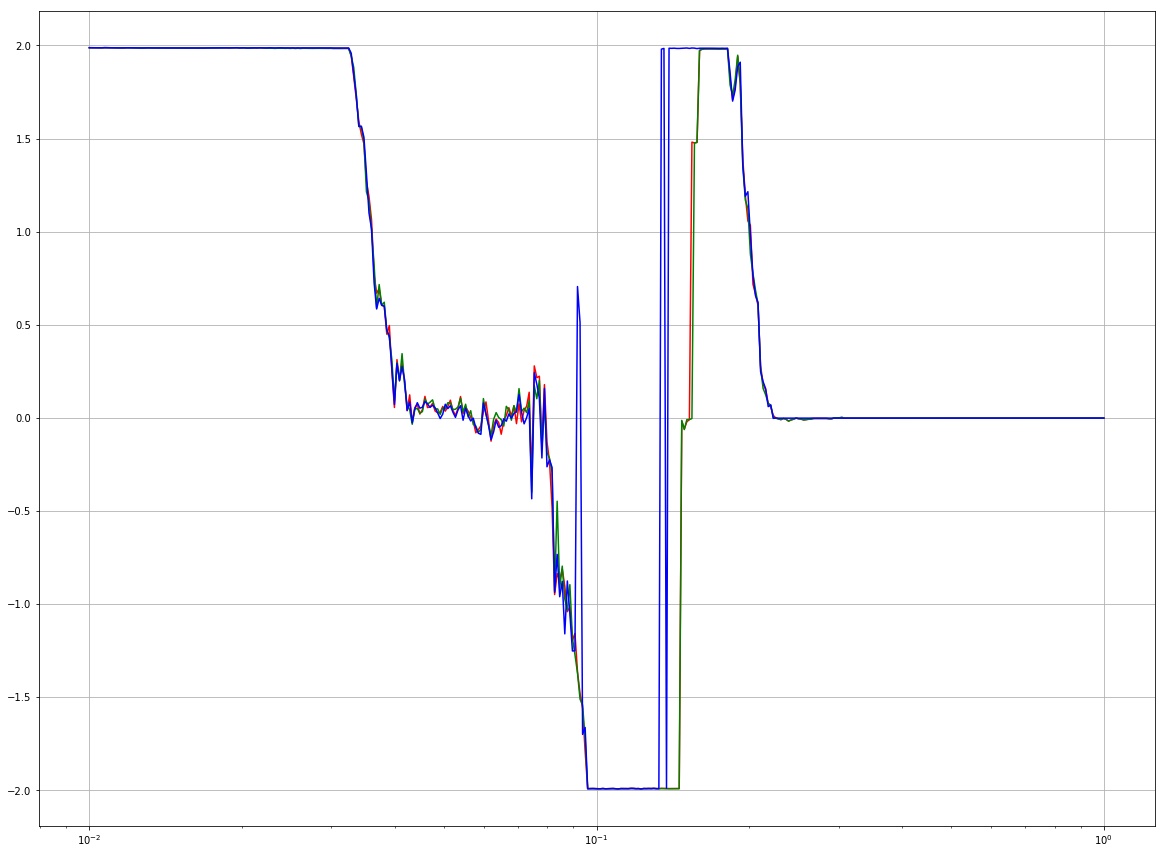

In [16]:
plt.figure(figsize=(20,15))
plt.semilogx(np.logspace(-2,0,400), x0, color='red')
plt.semilogx(np.logspace(-2,0,400), x1, color='green')
plt.semilogx(np.logspace(-2,0,400), np.squeeze(out[:,1,:]), color='blue')
plt.grid()

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


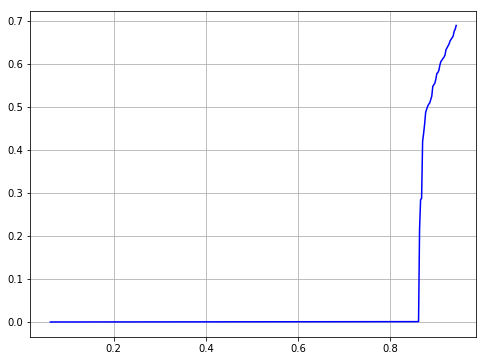

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(np.linspace(0.01*2*math.pi,0.15*2*math.pi,400), np.squeeze(out[:,1,:]), color='blue')
plt.grid()

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


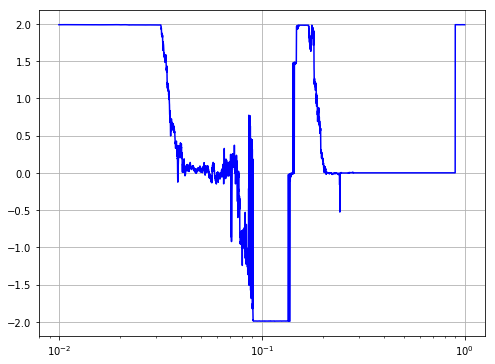

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.semilogx(np.logspace(-2,0,4096), np.squeeze(out[:,1,:]), color='blue')
plt.grid()

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


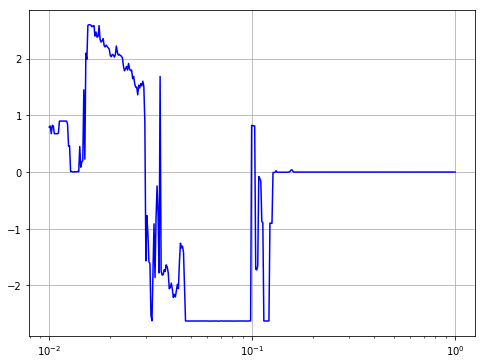

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.semilogx(np.logspace(-2,0,400), np.squeeze(out[:,1,:]), color='blue')
plt.grid()

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


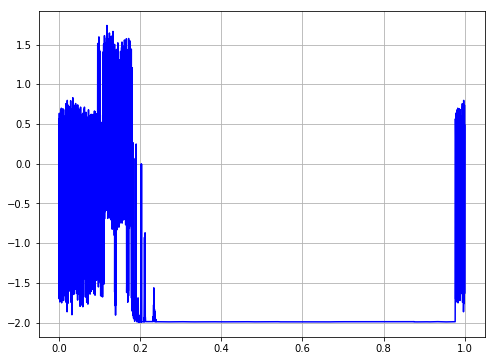

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(np.linspace(0,1,4096), np.squeeze(out[:,1,:]), color='blue')
plt.grid()

# testy

### papers

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown
INFO:root:block: (400, 1, 1); grid: (1, 1, 1)
INFO:root:RHS: ['v', '1.0*(-1.0*v + 8.55*cosf(12.38*t) - 6.28318530717959*cosf(6.28318530717959*x) + 0.5)/m']



400
kernel_calls: 1000
(400, 6, 1)
array([[[ 5.2693586e+00],
        [ 1.9880627e+00],
        [ 1.1123271e+07],
        [ 1.0086841e+03],
        [ 5.0508597e+02],
        [ 8.4219240e+10]],

       [[ 5.2873187e+00],
        [ 1.9879153e+00],
        [ 1.1131723e+07],
        [ 1.0086835e+03],
        [ 5.0508530e+02],
        [ 8.4219363e+10]],

       [[ 5.3241544e+00],
        [ 1.9877722e+00],
        [ 1.1144547e+07],
        [ 1.0086823e+03],
        [ 5.0508481e+02],
        [ 8.4219511e+10]],

       ...,

       [[-1.0119169e+00],
        [-5.2838045e-04],
        [ 4.3364028e+05],
        [-2.6791665e-01],
        [-2.3652552e-01],
        [ 2.8458594e+03]],

       [[-9.9773961e-01],
        [-5.2690535e-04],
        [ 4.2111191e+05],
        [-2.6715741e-01],
        [-2.3654526e-01],
        [ 2.7648167e+03]],

       [[-9.8375607e-01],
        [-5.2541745e-04],
        [ 4.0874716e+05],
        [-2.6641524e-01],
        [-2.3656622e-01],
        [ 2.6879990e+03]]], dty

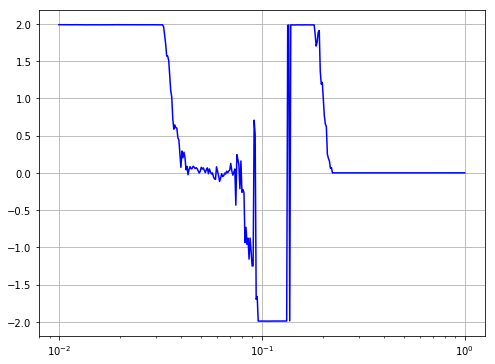

In [22]:
%matplotlib inline
sde = SDE.load_config('./out/config_slapik_2018_fig8a.pkl')
sde.solve(sde.settings)
plt.figure(figsize=(8,6))
plt.semilogx(np.logspace(-2,0,400), np.squeeze(out[:,1,:]), color='blue')
plt.grid()

{'constants': {'afterstep_every': 1000,
               'periods': 100,
               'steps_per_kernel_call': 1,
               'steps_per_period': 200,
               'transients': 0.1},
 'debug': {'enabled': False},
 'gpu': {'cuda': True,
         'device': 1,
         'max_blocks_per_grid': 2147483647,
         'max_threads_per_block': 1024,
         'regenerate_cu': True,
         'warp_size': 32},
 'output': {'config_filename': 'config.pkl',
            'folder_path': './out/',
            'kernel_filename': 'kernel.cu'},
 'simulation': {'block_size': None,
                'fit_to_warp_size': False,
                'grid_size': None,
                'integration_method': 'rk4',
                'number_of_threads': None,
                'paths': 1,
                'precision': 'float',
                'rng_seed': 123456789}}


INFO:root:block: (1, 1, 1); grid: (1, 1, 1)
INFO:root:RHS: ['v', '-0.13*v - sinf(x) + 1.62151*cosf(0.59999999999999998*t) + 0.014']



Initializing...
threads 1
kernel_calls: 20000


Path: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


(1, 6)
array([[-9.3779290e-01, -1.1290754e+00,  8.7848461e+04, -9.8651941e+02,
        -2.2189633e+02,  2.6557601e+09]], dtype=float32)

        0: v
        1: mean_v
        2: std_dev_v
        3: x
        4: mean_x
        5: std_dev_x
        


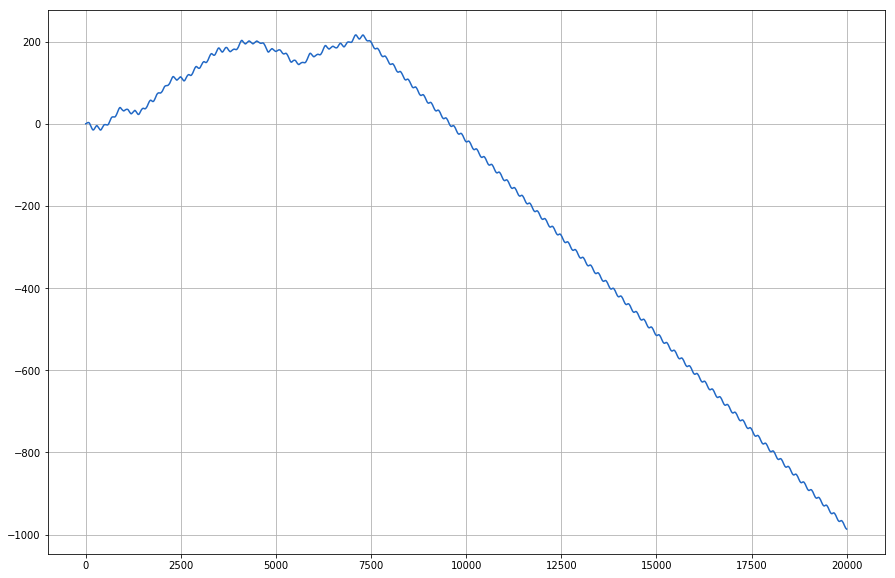

In [3]:
# praca michała

import math

sde = SDE(
    SDE_Param('gamma', 0.13),
    SDE_Param('a', 1.62151),
    SDE_Param('omega', 0.6),
    SDE_Param('f', 0.014),#np.linspace(-0.04,0.04,1000)),
    SDE_Param('D', 0),
    SDE_Noise('xi', 'normal'),
    SDE_VarDependent('x', 0.0, 0),
    SDE_VarDependent('v', 0.0, 1),
    SDE_VarIndependent('t', 0.0,  2*math.pi/(0.6*200)),
)
from variables_namespace import gamma, a, omega, f, D, xi, x, v, t
sde.rhs = [
    v,
    - gamma * v - sympy.sin(x) + a * sympy.cos(omega * t) + f + sympy.sqrt(2*gamma*D) * xi
]

settings = sde.get_default_settings()
settings['constants']['steps_per_kernel_call'] = 1
settings['constants']['steps_per_period'] = spp = 200
settings['constants']['periods'] = periods = 100
settings['constants']['transients'] = 0.1
settings['simulation']['paths'] = paths = 1
pprint.pprint(settings)

class Callback:
    def __init__(self, paths, periods, spp):
        self.trajectory = np.zeros((paths, periods*spp))
        self.trajectories = []
        self.path = 0
    def post_kernel_call(self, **l):
        self.trajectories.append(sde.get_values()[0,3])
    def post_path(self, **l):
        self.trajectory[self.path, :] = np.array(self.trajectories)
        self.trajectories = []
        self.path += 1
c = Callback(paths, periods, spp)
sde.register_callback(c.post_kernel_call, 'post_kernel_call')
sde.register_callback(c.post_path, 'post_path')

out = sde.solve(settings)

### plot ###

%matplotlib inline
import matplotlib.pyplot as plt
import random
plt.figure(figsize=(15,10))
for i in range(paths):
    plt.plot(list(range(periods*spp)), c.trajectory[i, :], color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)))
plt.grid()

### 1

In [ ]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html

from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

def f(z, t):
    x, v = z
    dzdt = [np.cos(v), np.cos(x)]
    return dzdt

z0 = [0, 10*np.sin(np.pi/4)]
t = [0.001*x for x in range(8000)]

sol = odeint(f, z0, t)

plt.plot(sol[:, 0], 'r')
plt.plot(sol[:, 1], 'g')
plt.show()

print(sol)
print(np.mean(np.array(sol), axis=0))

vals_solver = np.array([*sol[-1,:],*np.mean(np.array(sol), axis=0)])
print(vals_solver)

In [ ]:
import pprint

sde = SDE(
    SDE_Param('m', 1.0),
    SDE_Param('f', 9.8125),
    SDE_VarDependent('position', 0.0, 0),
    SDE_VarDependent('velocity', 10*np.sin(np.pi/4), 1),
    SDE_VarIndependent('t', 0.0, 0.001),
)
sde.rhs = [sympy.cos(velocity), sympy.cos(position)]
settings = sde.get_default_settings()
settings['constants']['steps_per_kernel_call'] = 1000
settings['constants']['steps_per_period'] = 8000
settings['constants']['periods'] = 1
settings['simulation']['integration_method'] = 'rk4'
pprint.pprint(settings)
print("""
        0: v
        1: mean_v
        2: std_dev_v
        3: x
        4: mean_x
        5: std_dev_x
        """)
vals_sde = sde.solve(settings)
vals_sde = np.array([vals_sde[0,3,0],vals_sde[0,0,0],vals_sde[0,4,0],vals_sde[0,1,0]])
print(vals_sde)

In [ ]:
print('rk4')
print('x','v','mean_x','mean_v')
vals_solver - vals_sde

In [ ]:
print('euler')
print('x','v','mean_x','mean_v')
vals_solver - vals_sde

### 2

In [ ]:
sde = SDE(
    SDE_Param('b', 0.25),
    SDE_Param('c', 5.0),
    SDE_VarDependent('position', np.pi - 0.1, 0),
    SDE_VarDependent('velocity', 0.0, 1),
    SDE_VarIndependent('t', 0.0, 0.001),
)
rhs = -b*velocity - c*sympy.sin(position)
settings = sde.get_default_settings()
settings['simulation']['steps_per_period'] = settings['simulation']['steps_per_kernel_call'] = 10000
print(settings)
sde.solve(rhs, settings)

In [ ]:
import numpy as np, matplotlib.pyplot as plt, matplotlib.font_manager as fm,os
from scipy.integrate import odeint
from mpl_toolkits.mplot3d.axes3d import Axes3D

initial_state = [0.1, 0, 0, 1,1,1]
a = 4
time_points = np.linspace(0, 100, 10000)

def my_system(current_state, t):
    theta1, theta2, theta3, omega1, omega2, omega3 = current_state

    d2theta1_dt2 = -a*(2*theta1-theta2-theta3)
    d2theta2_dt2 = -a*(2*theta2-theta1-theta3)
    d2theta3_dt2 = -a*(2*theta3-theta1-theta2)

    return [ omega1, omega2, omega3, d2theta1_dt2, d2theta2_dt2, d2theta3_dt2]

xyz = odeint(my_system, initial_state, time_points)

theta1 = xyz[:, 0]
theta2 = xyz[:, 1]
theta3 = xyz[:, 2]

fig = plt.figure(figsize=(12, 9))
ax = fig.gca(projection='3d')
ax.xaxis.set_pane_color((1,1,1,1))
ax.yaxis.set_pane_color((1,1,1,1))
ax.zaxis.set_pane_color((1,1,1,1))
ax.plot(theta1, theta2, theta3, color='g', alpha=0.7, linewidth=0.6)
ax.set_title('plot')
plt.show()

### 3

In [ ]:
sde = SDE(
    SDE_Param('m', 0.1),
    SDE_Param('gamma', 1.0),
    SDE_Param('a', 8.55),
    SDE_Param('omega', 12.38),
    SDE_Param('f', 0.5),
    SDE_VarDependent('position', 0.0, 0),
    SDE_VarDependent('velocity', 0.0, 1),
    SDE_VarIndependent('t', 0.0,  2*np.pi/3000),
    SDE_Function('U', lambda x: sympy.sin(2*np.pi*x))
)
rhs = [
    velocity,
    1.0 / m * (-gamma * velocity - sympy.diff(U(position), position) + a * sympy.cos(omega * t) + f)
]
settings = sde.get_default_settings()
settings['simulation']['periods'] = 1000
settings['simulation']['steps_per_period'] = 800
pprint.pprint(settings)
sde.solve(rhs, settings)

######

print('data:\n', sde.data)

init_printing()
print('\n\nequation:\n')
display(sde.rhs)
print('\n\nfree symbols:\n')
display(list(eq.free_symbols for eq in sde.rhs))
print('\n\nequation with substituted [0]values:\n')
display(list(eq.subs(sde.get_0subs()) for eq in sde.rhs))
# display(rhs.subs(Value.subs_uneval()))

### 4

{'constants': {'afterstep_every': 1000,
               'periods': 1,
               'steps_per_kernel_call': 1,
               'steps_per_period': 100},
 'debug': {'enabled': True},
 'gpu': {'cuda': True,
         'device': 1,
         'max_blocks_per_grid': 2147483647,
         'max_threads_per_block': 1024,
         'regenerate_cu': True,
         'warp_size': 32},
 'output': {'config_filename': 'config.pkl',
            'folder_path': './out/',
            'kernel_filename': 'kernel.cu'},
 'simulation': {'block_size': None,
                'fit_to_warp_size': False,
                'grid_size': None,
                'integration_method': 'rk4',
                'number_of_threads': None,
                'paths': 1,
                'precision': 'float'}}
  sympy_symbol                  type   values   step derivative_order
m            m             parameter     [10]   None             None
F            F             parameter  [-98.1]   None             None
x            x    depend

INFO:root:block: (1, 1, 1); grid: (1, 1, 1)
INFO:root:RHS: ['v', '-9.8100000000000005']


Path: 100%|██████████| 1/1 [00:00<00:00, 45.32it/s]

Initializing...
watki 1
kernel_calls: 100
(1, 6, 1)



DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


array([[[-3.0821964e+01],
        [-7.1508926e-01],
        [ 3.0824537e+04]]], dtype=float32)

        0: v
        1: mean_v
        2: std_dev_v
        3: x
        4: mean_x
        5: std_dev_x
        
sdepy
[1.8411453, 3.6445808, 5.410307, 7.1383233, 8.82863, 10.481228, 12.096115, 13.673293, 15.212762, 16.714521, 18.17857, 19.60491, 20.99354, 22.34446, 23.657671, 24.933172, 26.170963, 27.371046, 28.533419, 29.658081, 30.745035, 31.79428, 32.805813, 33.779636, 34.71575, 35.61416, 36.474854, 37.29784, 38.08312, 38.830685, 39.540543, 40.21269, 40.847126, 41.443855, 42.002872, 42.52418, 43.007782, 43.45367, 43.86185, 44.232323, 44.565083, 44.860134, 45.117477, 45.33711, 45.51903, 45.663242, 45.769745, 45.83854, 45.86962, 45.862995, 45.81866, 45.736614, 45.61686, 45.459396, 45.26422, 45.031338, 44.760746, 44.452442, 44.10643, 43.722706, 43.301273, 42.842133, 42.34528, 41.81072, 41.23845, 40.628468, 39.980778, 39.29538, 38.57227, 37.81145, 37.012924, 36.176685, 35.30274, 34.39108, 33

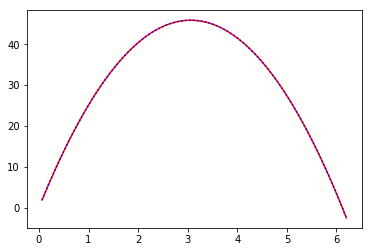

In [9]:
# parabola (OK!)

X = []
def f(**loc):
    if loc['path']==loc['s']['simulation']['paths']-1:
        loc['mod'].get_function("get_values")(loc['output_gpu'], block=loc['s']['simulation']['block_size'], grid=loc['s']['simulation']['grid_size'])
        X.append(loc['output_gpu'].get()[0,3,0])

sde = SDE(
    SDE_Param('m', 10),
    SDE_Param('F', -98.1),
    SDE_VarDependent('x', 0.0, 0),
    SDE_VarDependent('v', 30.0, 1),
    SDE_VarIndependent('t', 0.0,  0.062),
)
sde.rhs = [
    v,
    F/m
]
settings = sde.get_default_settings()
settings['simulation']['paths'] = 1
settings['constants']['periods'] = 1
settings['constants']['steps_per_kernel_call'] = 1
settings['constants']['steps_per_period'] = 100
pprint.pprint(settings)
print(sde.data)
sde.register_callback(f, 'post_kernel_call')

out = sde.solve(settings)

###

%matplotlib inline
import matplotlib.pyplot as plt

T = np.arange(1, sde.settings['constants']['steps_per_period']+1) * list(sde.row_iterator('type', 'independent variable'))[0].step

plt.plot(T, X, c='r',linestyle='-')
print('sdepy')
print(X)

x = 30 * T - T**2*9.81/2
plt.plot(T,x,c='b',linestyle=':')
print('analytical')
print(x)

## 5

INFO:root:block: (1, 1, 1); grid: (1, 1, 1)

{'constants': {'afterstep_every': 1000,
               'periods': 1,
               'steps_per_kernel_call': 1,
               'steps_per_period': 100},
 'debug': {'enabled': True},
 'gpu': {'cuda': True,
         'device': 1,
         'max_blocks_per_grid': 2147483647,
         'max_threads_per_block': 1024,
         'regenerate_cu': True,
         'warp_size': 32},
 'output': {'config_filename': 'config.pkl',
            'folder_path': './out/',
            'kernel_filename': 'kernel.cu'},
 'simulation': {'block_size': None,
                'fit_to_warp_size': False,
                'grid_size': None,
                'integration_method': 'rk4',
                'number_of_threads': None,
                'paths': 100,
                'precision': 'float'}}
  sympy_symbol                  type  values  step derivative_order
x            x    dependent variable     1.0  None                0
v            v    dependent variable     0.0  None                1
t            t  independent 


INFO:root:RHS: ['-2*sinf(2*t)', '-4*cosf(2*t)']


Path:   0%|          | 0/100 [00:00<?, ?it/s]

Initializing...
watki 1
kernel_calls: 100


Path: 100%|██████████| 100/100 [00:00<00:00, 512.29it/s]
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


(1, 6, 1)
array([[[  1.0880332 ],
        [ -0.36206725],
        [178.38399   ]]], dtype=float32)

        0: v
        1: mean_v
        2: std_dev_v
        3: x
        4: mean_x
        5: std_dev_x
        
sdepy x
[0.9950042, 0.9800666, 0.9553365, 0.92106104, 0.8775826, 0.8253357, 0.7648423, 0.6967068, 0.62161005, 0.5403024, 0.4535962, 0.36235783, 0.26749888, 0.16996719, 0.070737235, -0.02919949, -0.12884447, -0.22720207, -0.32328954, -0.4161468, -0.5048461, -0.5885011, -0.666276, -0.7373937, -0.8011436, -0.8568888, -0.9040722, -0.9422225, -0.97095835, -0.98999274, -0.9991355, -0.9982952, -0.9874803, -0.9667988, -0.9364574, -0.8967592, -0.84810096, -0.7909688, -0.7259335, -0.6536449, -0.57482535, -0.4902623, -0.4008007, -0.30733445, -0.21079743, -0.11215418, -0.012390325, 0.08749733, 0.18651076, 0.28366062, 0.37797627, 0.4685153, 0.5543731, 0.6346918, 0.7086689, 0.7755652, 0.8347123, 0.8855193, 0.9274785, 0.9601706, 0.9832691, 0.9965431, 0.99986, 0.9931866, 0.9765897, 0.950235, 

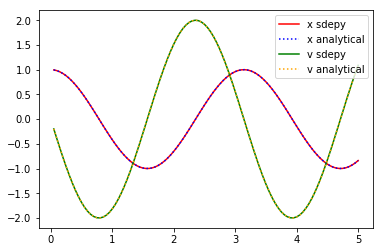

In [11]:
# sin/cos

X = []
V = []
def f(out):
    X.append(out[0,3,0])
    V.append(out[0,0,0])

sde = SDE(
    SDE_VarDependent('x', 1.0, 0),
    SDE_VarDependent('v', 0.0, 1),
    SDE_VarIndependent('t', 0.0,  0.05),
)
sde.rhs = [
    -2 * sympy.sin(2*t),
    -4 * sympy.cos(2*t)
]
settings = sde.get_default_settings()
settings['simulation']['paths'] = 100
settings['constants']['periods'] = 1
settings['constants']['steps_per_kernel_call'] = 1
settings['constants']['steps_per_period'] = 100
pprint.pprint(settings)
print(sde.data)
sde.callback = f

out = sde.solve(settings)

###

%matplotlib inline
import matplotlib.pyplot as plt

T = np.arange(1,1+sde.settings['constants']['steps_per_period']) * list(sde.row_iterator('type', 'independent variable'))[0].step

plt.plot(T, X, c='r',linestyle='-', label='x sdepy')
print('sdepy x')
print(X)

x = np.cos(2*T)
plt.plot(T,x,c='b',linestyle=':', label='x analytical')
print('analytical x')
print(x)

plt.plot(T, V, c='g',linestyle='-', label='v sdepy')
print('sdepy v')
print(V)

v = -2 * np.sin(2*T)
plt.plot(T,v,c='orange',linestyle=':', label='v analytical')
print('analytical v')
print(v)

plt.legend()

## 6

{'constants': {'afterstep_every': 1000,
               'periods': 1,
               'steps_per_kernel_call': 1,
               'steps_per_period': 100},
 'debug': {'enabled': True},
 'gpu': {'cuda': True,
         'device': 1,
         'max_blocks_per_grid': 2147483647,
         'max_threads_per_block': 1024,
         'regenerate_cu': True,
         'warp_size': 32},
 'output': {'config_filename': 'config.pkl',
            'folder_path': './out/',
            'kernel_filename': 'kernel.cu'},
 'simulation': {'block_size': None,
                'fit_to_warp_size': False,
                'grid_size': None,
                'integration_method': 'rk4',
                'number_of_threads': None,
                'paths': 100,
                'precision': 'float'}}
  sympy_symbol                  type  values   step derivative_order
x            x    dependent variable     1.0   None                0
t            t  independent variable     2.0  0.005             None


INFO:root:block: (1, 1, 1); grid: (1, 1, 1)
INFO:root:RHS: ['5*x - 3']


Path:   0%|          | 0/100 [00:00<?, ?it/s]

Initializing...
watki 1
kernel_calls: 100


Path: 100%|██████████| 100/100 [00:00<00:00, 526.08it/s]
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


(1, 3, 1)
array([[[  5.4729977],
        [  2.411657 ],
        [155.40327  ]]], dtype=float32)

        0: v
        1: mean_v
        2: std_dev_v
        3: x
        4: mean_x
        5: std_dev_x
        
sdepy x
[1.010126, 1.0205084, 1.0311537, 1.0420684, 1.0532594, 1.0647337, 1.0764985, 1.0885612, 1.1009291, 1.1136103, 1.1266124, 1.1399437, 1.1536125, 1.1676272, 1.1819968, 1.1967301, 1.2118365, 1.2273252, 1.243206, 1.2594888, 1.2761838, 1.2933015, 1.3108525, 1.3288479, 1.3472987, 1.3662167, 1.3856136, 1.4055015, 1.4258928, 1.4468004, 1.4682372, 1.4902167, 1.5127527, 1.5358591, 1.5595505, 1.5838417, 1.6087477, 1.6342843, 1.6604673, 1.6873131, 1.7148385, 1.7430608, 1.7719976, 1.8016669, 1.8320872, 1.8632776, 1.8952576, 1.9280472, 1.9616668, 1.9961376, 2.031481, 2.0677192, 2.1048746, 2.1429708, 2.1820314, 2.2220807, 2.2631438, 2.3052464, 2.348415, 2.392676, 2.438058, 2.4845886, 2.5322971, 2.5812135, 2.6313682, 2.6827924, 2.7355185, 2.7895794, 2.8450089, 2.9018414, 2.9601128, 3.0198

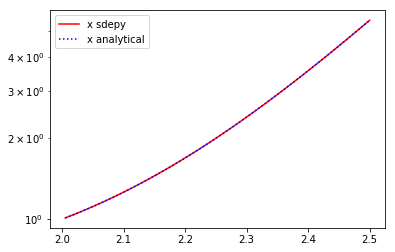

In [13]:
# 1ODE

X = []
def f(out):
    X.append(out[0,0,0])

sde = SDE(
    SDE_VarDependent('x', 1.0, 0),
    SDE_VarIndependent('t', 2.0,  0.005),
)
sde.rhs = [
    5 * x - 3,
]
settings = sde.get_default_settings()
settings['simulation']['paths'] = 100
settings['constants']['periods'] = 1
settings['constants']['steps_per_kernel_call'] = 1
settings['constants']['steps_per_period'] = 100
pprint.pprint(settings)
print(sde.data)
sde.callback = f

out = sde.solve(settings)

###

%matplotlib inline
import matplotlib.pyplot as plt

T = np.arange(1,1+sde.settings['constants']['steps_per_period']) * list(sde.row_iterator('type', 'independent variable'))[0].step + 2

plt.plot(T, X, c='r',linestyle='-', label='x sdepy')
print('sdepy x')
print(X)

x = 2/5 * np.exp(5*T - 10) + 3/5
plt.plot(T,x,c='b',linestyle=':', label='x analytical')
print('analytical x')
print(x)

plt.gca().set_yscale('log')

plt.legend()

## 7

INFO:root:block: (1, 1, 1); grid: (1, 1, 1)

{'constants': {'afterstep_every': 1000,
               'periods': 1,
               'steps_per_kernel_call': 1,
               'steps_per_period': 100},
 'debug': {'enabled': True},
 'gpu': {'cuda': True,
         'device': 1,
         'max_blocks_per_grid': 2147483647,
         'max_threads_per_block': 1024,
         'regenerate_cu': True,
         'warp_size': 32},
 'output': {'config_filename': 'config.pkl',
            'folder_path': './out/',
            'kernel_filename': 'kernel.cu'},
 'simulation': {'block_size': None,
                'fit_to_warp_size': False,
                'grid_size': None,
                'integration_method': 'rk4',
                'number_of_threads': None,
                'paths': 100,
                'precision': 'float'}}
   sympy_symbol                  type  values  step derivative_order
y1           y1    dependent variable     2.0  None                0
y2           y2    dependent variable     0.0  None                1
t             t  independ


INFO:root:RHS: ['y2', '-y1 + y2*(-powf(y1, 2) + 1)']


Path:   0%|          | 0/100 [00:00<?, ?it/s]

Initializing...
watki 1
kernel_calls: 100


Path: 100%|██████████| 100/100 [00:00<00:00, 613.30it/s]
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


(1, 6, 1)
array([[[-3.5920013e-02],
        [ 2.4448792e-04],
        [ 2.0580829e+02]]], dtype=float32)

        0: v
        1: mean_v
        2: std_dev_v
        3: x
        4: mean_x
        5: std_dev_x
        
sdepy x
[1.966859, 1.8881059, 1.781535, 1.6543701, 1.5082234, 1.3412999, 1.1490191, 0.9237273, 0.6538992, 0.32366112, -0.08437364, -0.5747213, -1.1050988, -1.5683129, -1.8655764, -1.9917405, -2.0023787, -1.9480267, -1.8569747, -1.7420857, -1.6079764, -1.4547915, -1.2796894, -1.0770642, -0.83801794, -0.5495126, -0.19448191, 0.24265528, 0.7550496, 1.2768477, 1.6908029, 1.9256685, 2.0055802, 1.9895598, 1.920486, 1.8203988, 1.6987281, 1.5582865, 1.3981142, 1.2144501, 1.0006576, 0.74652445, 0.43750548, 0.055905886, -0.40970707, -0.936408, -1.4349275, -1.7909688, -1.9671524, -2.0082529, -1.970632, -1.889369, -1.7813252, -1.653199, -1.5063224, -1.3387408, -1.145765, -0.91964453, -0.6487532, -0.31712642, 0.09258871, 0.58441913, 1.114844, 1.5757803, 1.8696396, 1.9930731, 2.002085

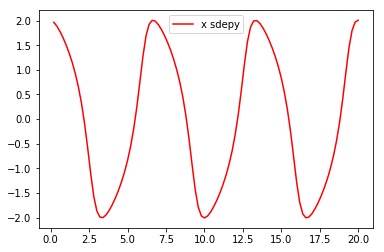

In [14]:
# 2ODE

X = []
def f(out):
    X.append(out[0,3,0])

sde = SDE(
    SDE_VarDependent('y1', 2.0, 0),
    SDE_VarDependent('y2', 0.0, 1),
    SDE_VarIndependent('t', 0.0,  0.2),
)
sde.rhs = [
    y2,
    (1-y1**2)*y2-y1
]
settings = sde.get_default_settings()
settings['simulation']['paths'] = 100
settings['constants']['periods'] = 1
settings['constants']['steps_per_kernel_call'] = 1
settings['constants']['steps_per_period'] = 100
pprint.pprint(settings)
print(sde.data)
sde.callback = f

out = sde.solve(settings)

###

%matplotlib inline
import matplotlib.pyplot as plt

T = np.arange(1,1+sde.settings['constants']['steps_per_period']) * list(sde.row_iterator('type', 'independent variable'))[0].step

plt.plot(T, X, c='r',linestyle='-', label='x sdepy')
print('sdepy x')
print(X)

# x = 2/5 * np.exp(5*T - 10) + 3/5
# plt.plot(T,x,c='b',linestyle=':', label='x analytical')
# print('analytical x')
# print(x)

plt.legend()

## 8

{'constants': {'afterstep_every': 1000,
               'periods': 1,
               'steps_per_kernel_call': 1,
               'steps_per_period': 100},
 'debug': {'enabled': True},
 'gpu': {'cuda': True,
         'device': 1,
         'max_blocks_per_grid': 2147483647,
         'max_threads_per_block': 1024,
         'regenerate_cu': True,
         'warp_size': 32},
 'output': {'config_filename': 'config.pkl',
            'folder_path': './out/',
            'kernel_filename': 'kernel.cu'},
 'simulation': {'block_size': None,
                'fit_to_warp_size': False,
                'grid_size': None,
                'integration_method': 'rk4',
                'number_of_threads': None,
                'paths': 100,
                'precision': 'float'}}
      sympy_symbol                  type   values  step derivative_order
b                b             parameter   [0.25]  None             None
c                c             parameter    [5.0]  None             None
theta        

INFO:root:block: (1, 1, 1); grid: (1, 1, 1)
INFO:root:RHS: ['omega', '-0.25*omega - 5.0*sinf(theta)']


Path:   0%|          | 0/100 [00:00<?, ?it/s]

Initializing...
watki 1
kernel_calls: 100


Path: 100%|██████████| 100/100 [00:00<00:00, 450.83it/s]
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


(1, 6, 1)
array([[[ 1.5678960e+00],
        [-2.9433936e-01],
        [ 3.4235339e+02]]], dtype=float32)

        0: v
        1: mean_v
        2: std_dev_v
        3: x
        4: mean_x
        5: std_dev_x
        
sde [-0.049706616, -0.100637555, -0.15527019, -0.21619344, -0.28622237, -0.36851245, -0.4666713, -0.584858, -0.7278503, -0.9010341, -1.1102355, -1.36125, -1.6588409, -2.0048807, -2.3953097, -2.8158708, -3.237539, -3.6143765, -3.8882458, -4.003447, -3.927308, -3.6644237, -3.2536936, -2.7504923, -2.2068257, -1.6597329, -1.1291995, -0.62157804, -0.13452707, 0.33851656, 0.8047092, 1.2686664, 1.7293919, 2.1771996, 2.5913186, 2.9398706, 3.1843855, 3.2896316, 3.2357662, 3.026329, 2.6868536, 2.255105, 1.7691847, 1.2593354, 0.7452478, 0.23746908, -0.25923884, -0.74207145, -1.2065659, -1.6435429, -2.0371077, -2.3646004, -2.5994906, -2.7173858, -2.7034407, -2.557739, -2.2956219, -1.942811, -1.5281892, -1.0777488, -0.6116007, -0.1439631, 0.31494626, 0.75624335, 1.1697766, 1.5422424,

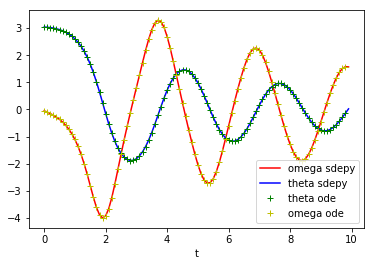

In [18]:
# wahadło tłumione

X = []
V = []
def f(out):
    X.append(out[0,0,0])
    V.append(out[0,3,0])

sde = SDE(
    SDE_Param('b', 0.25),
    SDE_Param('c', 5.0),
    SDE_VarDependent('theta', np.pi - 0.1, 0),
    SDE_VarDependent('omega', 0.0, 1),
    SDE_VarIndependent('t', 0.0,  0.1),
)
sde.rhs = [
    omega,
    -b * omega -c * sympy.sin(theta)
]
settings = sde.get_default_settings()
settings['simulation']['paths'] = 100
settings['constants']['periods'] = 1
settings['constants']['steps_per_kernel_call'] = 1
settings['constants']['steps_per_period'] = 100
settings['simulation']['integration_method'] = 'rk4'
pprint.pprint(settings)
print(sde.data)
sde.callback = f

out = sde.solve(settings)

###

%matplotlib inline
import matplotlib.pyplot as plt

T = np.arange(sde.settings['constants']['steps_per_period']) * list(sde.row_iterator('type', 'independent variable'))[0].step

plt.plot(T, X, c='r',linestyle='-', label='omega sdepy')
plt.plot(T, V, c='b',linestyle='-', label='theta sdepy')
print('sde', X)

###
def pend(y, t, b, c):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt
b = 0.25
c = 5.0
y0 = [np.pi - 0.1, 0.0]
from scipy.integrate import odeint
sol = odeint(pend, y0, T, args=(b, c))
plt.plot(T[:-1], sol[1:, 0], 'g+', label='theta ode')
plt.plot(T[:-1], sol[1:, 1], 'y+', label='omega ode')
plt.xlabel('t')
print('ode', sol[:,1])
###

plt.legend()

# notes

In [ ]:
# generowanie liczb losowych

import numpy as np
import pycuda.autoinit
from pycuda.compiler import SourceModule
from pycuda import gpuarray

code = """
    #include <curand_kernel.h>

    const int nstates = %(NGENERATORS)s;
    __device__ curandState_t* states[nstates];

    __global__ void initkernel(int seed)
    {
        int tidx = threadIdx.x + blockIdx.x * blockDim.x;

        if (tidx < nstates) {
            curandState_t* s = new curandState_t;
            if (s != 0) {
                curand_init(seed, tidx, 0, s);
            }

            states[tidx] = s;
        }
    }

    __global__ void randfillkernel(float *values, int N)
    {
        int tidx = threadIdx.x + blockIdx.x * blockDim.x;

        if (tidx < nstates) {
            curandState_t s = *states[tidx];
            for(int i=tidx; i < N; i += blockDim.x * gridDim.x) {
                values[i] = curand_uniform(&s);
            }
            *states[tidx] = s;
        }
    }
"""

N = 1
mod = SourceModule(code % { "NGENERATORS" : N }, no_extern_c=True)
init_func = mod.get_function("_Z10initkerneli")
fill_func = mod.get_function("_Z14randfillkernelPfi")

seed = np.int32(123456789)
nvalues = 10 * N
init_func(seed, block=(N,1,1), grid=(1,1,1))
gdata = gpuarray.zeros(nvalues, dtype=np.float32)
print(gdata)
fill_func(gdata, np.int32(nvalues), block=(N,1,1), grid=(1,1,1))
print(gdata)

In [ ]:
#plotly

import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

m = 0.2
g = 9.81
steps = 100

alpha = 89
v_0 = 30
f = np.array([0, -m*g]) # x, y
pos = np.zeros((steps, 2))
v = np.zeros((steps, 2))
v[0, :] = v_0 * np.cos(np.radians(alpha)), v_0 * np.sin(np.radians(alpha))
a = f/m
t = 0
dt = 0.1

last_i = 0
for i in range(steps-1):
    last_i = i
    v[i+1, :] = v[i, :] + a*dt
    pos[i+1, :] = pos[i, :] + v[i]*dt
    if pos[i+1, 1] < 0:
        break

poss = go.Scatter(
    x=pos[:last_i,0],
    y=pos[:last_i,1],
    mode = 'markers'
)

vs = go.Scatter(
    x=pos[:last_i,0],
    y=np.abs(v[:last_i,1]),
    mode = 'markers'
)

data = [poss, vs]

fig = go.Figure(data=data)

iplot(fig)

In [ ]:
# runge-kutta 4th order

# https://pl.wikipedia.org/wiki/Algorytm_Rungego-Kutty
# https://www.geeksforgeeks.org/runge-kutta-4th-order-method-solve-differential-equation/

# predictor-corrector

# http://www.cmth.ph.ic.ac.uk/people/a.mackinnon/Lectures/compphys/node12.html
idx//paths

In [ ]:
import functools
import operator
def indices_1D_ND(index, arrs):
    '''
    :param arrs:  array of arrays containing variables/parameters values
                  e.g.: [[0], [0,1,2,3,4,5,6], range(95,105), [2], [1], [0.1, 0.01, 0.001]]
    :param index: if all possible values combinations were produced from respectible subarrays and then flattened into 1D
                  this is gonna be an index of values set in such 1D array
    :returns:     array of indices for accessing desired values in arrs (indices in the same order as arrs)
    :raises ValueError: if index out of range
    '''
    indices_reversed = []
    lens = [len(x) for x in arrs]
    max_index = functools.reduce(operator.mul, lens, 1)
    if index < 0 or index >= max_index:
        raise ValueError('index >= {}'.format(max_index))
    for l in lens:
        indices_reversed.append(index%l)
        index = index // l
    return(indices_reversed)

aaa = [[0], [0,1,2,3,4,5,6], range(95,98), [2], [1], [0.1, 0.01, 0.001]]
x = 0
while(True):
    try:
        print(indices_1D_ND(x, aaa))
        x += 1
    except Exception:
        break

In [ ]:
import math
class Welford(object):
    """ Implements Welford's algorithm for computing a running mean
    and standard deviation as described at: 
        http://www.johndcook.com/standard_deviation.html
    can take single values or iterables
    Properties:
        mean    - returns the mean
        std     - returns the std
        meanfull- returns the mean and std of the mean
    Usage:
        >>> foo = Welford()
        >>> foo(range(100))
        >>> foo
        <Welford: 49.5 +- 29.0114919759>
        >>> foo([1]*1000)
        >>> foo
        <Welford: 5.40909090909 +- 16.4437417146>
        >>> foo.mean
        5.409090909090906
        >>> foo.std
        16.44374171455467
        >>> foo.meanfull
        (5.409090909090906, 0.4957974674244838)
    """

    def __init__(self,lst=None):
        self.k = 0
        self.M = 0
        self.S = 0
        self.__call__(lst)
    
    def update(self,x):
        if x is None:
            return
        self.k += 1
        newM = self.M + (x - self.M)*1./self.k
        newS = self.S + (x - self.M)*(x - newM)
        self.M, self.S = newM, newS

    def consume(self,lst):
#         lst = iter(lst)
        for x in lst:
            self.update(x)
    
    def __call__(self,x):
        if hasattr(x,"__iter__"):
            self.consume(x)
        else:
            self.update(x)
            
    @property
    def mean(self):
        return self.M
    @property
    def meanfull(self):
        return self.mean, self.std/math.sqrt(self.k)
    @property
    def std(self):
        if self.k==1:
            return 0
        return math.sqrt(self.S/(self.k-1))
    def __repr__(self):
        return "<Welford: {} +- {}>".format(self.mean, self.std)
    
import numpy as np
def aaa(x):
    for x in range(x):
        yield x*1000
#     yield -x*10000
lst = list(aaa(10000))
print(lst[-10:])
print(np.mean(lst))
print(np.std(lst))
Welford(lst)